In [1]:
using Agents, Random, DataFrames, LightGraphs
using Distributions: Poisson, DiscreteNonParametric
using DrWatson: @dict
using Plots
using Random
using InteractiveDynamics
using CairoMakie

using DifferentialEquations
using SimpleDiffEq
using StatsPlots

In [2]:
mutable struct Student <: AbstractAgent
    id::Int
    status::Symbol  # 1: S, 2: I, 3:R
end

function rate_to_proportion(r::Float64,t::Float64)
    1-exp(-r*t)
end;

function init_model(β :: Float64, c :: Float64, γ :: Float64, N :: Int64, I0 :: Int64)
    properties = @dict(β,c,γ)
    model = ABM(Student; properties=properties)
    for i in 1 : N
        if i <= I0
            s = :I
        else
            s = :S
        end
        p = Student(i,s)
        p = add_agent!(p,model)
    end
    return model
end;

function agent_step!(agent, model)
    transmit!(agent, model)
    recover!(agent, model)
end;

function transmit!(agent, model)
    # If I'm not susceptible, I return
    agent.status != :S && return
    ncontacts = rand(Poisson(model.properties[:c]))
    for i in 1:ncontacts
        # Choose random individual
        alter = random_agent(model)
        if alter.status == :I && (rand() ≤ model.properties[:β])
            # An infection occurs
            agent.status = :I
            break
        end
    end
end;

function recover!(agent, model)
    agent.status != :I && return
    if rand() ≤ model.properties[:γ]
            agent.status = :R
    end
end;

In [3]:
# These seem to be the same but with different names and encoded
# differently
susceptible(x) = count(i == :S for i in x)
infected(x) = count(i == :I for i in x)
recovered(x) = count(i == :R for i in x);

In [4]:
δt = 0.1
nsteps = 150
tf = nsteps * δt
t = 0 : δt : tf;

β = 0.25
c = 7.5 * δt
γ = rate_to_proportion(0.50, δt);

N = 763
I0 = 1;

Random.seed!(1234);

abm_model = init_model(β, c, γ, N, I0)

to_collect = [(:status, f) for f in (susceptible, infected, recovered)]
abm_data, _ = run!(abm_model, agent_step!, nsteps; adata = to_collect);

abm_data[!,:t] = t;

In [5]:
actuals = [1, 3, 8, 28, 76, 222, 293, 257, 237, 192, 126, 70, 28, 12, 5]

15-element Vector{Int64}:
   1
   3
   8
  28
  76
 222
 293
 257
 237
 192
 126
  70
  28
  12
   5

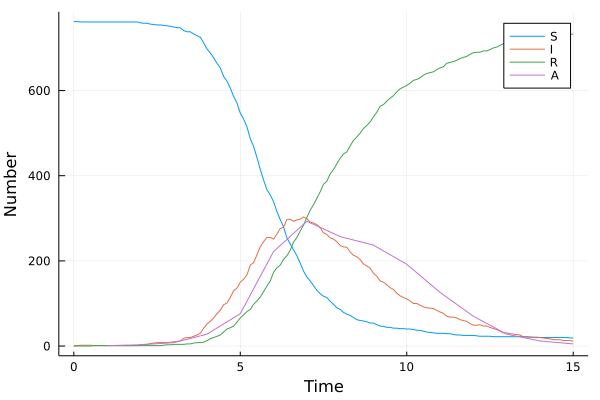

In [6]:
Plots.plot(t,abm_data[:,2],label="S",xlab="Time",ylabel="Number")
Plots.plot!(t,abm_data[:,3],label="I")
Plots.plot!(t,abm_data[:,4],label="R")
Plots.plot!(1:15, actuals, label="A")